# Projeto Final Deep Learning
#### Universidade do Pernambuco
#### Escola Politécnica do Pernambuco
#### Especialização em Ciência de dados e analytics
#### Alunos: Lucas Penteado, Geidson, Luiz Adeildo, Josafá

### 1. Carrega bibliotecas para o projeto

In [ ]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import cifar10
from keras import backend as K
import numpy as np


# bibliotecas para construir a CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Biblioteca para visualizar imagens
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Análise da base de dados

O CIFAR-10 é um conjunto de dados desenvolvido por pesquisadores do Instituto Canadense de Pesquisa Avançada - CIFAR. Esse conjunto de dados é muito conhecido e utilizado para benchmarking de algoritmos de visão computacional no campo de aprendizado de máquina.

É composto por 60000 mil imagens coloridas de 32 x 32 pixels de 10 classes:

- 0 - airplane
- 1 - automobile
- 2 - bird
- 3 - cat
- 4 - deer
- 5 - dog
- 6 - frog
- 7 - horse
- 8 - ship
- 9 - truck

Vamos analisar abaixo:

#### 2.1 Shapes de treinamento e teste

Existem 50 mil imagens para treinamento e 10 mil para testes. As imagens são quadradas com tamanho de 32 x 32 pixels e possuem 3 canais de cores.

In [ ]:
# carregar a base
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('')
print("Shape conjunto de treinamento:", x_train.shape, y_train.shape)
print("Shape conjunto de teste:", x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step

Shape conjunto de treinamento: (50000, 32, 32, 3) (50000, 1)
Shape conjunto de teste: (10000, 32, 32, 3) (10000, 1)


#### 2.2 Amostra de imagens

Abaixo temos um gráfico com 32 imagens exidadas aleatoriamente.

É possível notar que as imagens possuem baixíssima resolução.



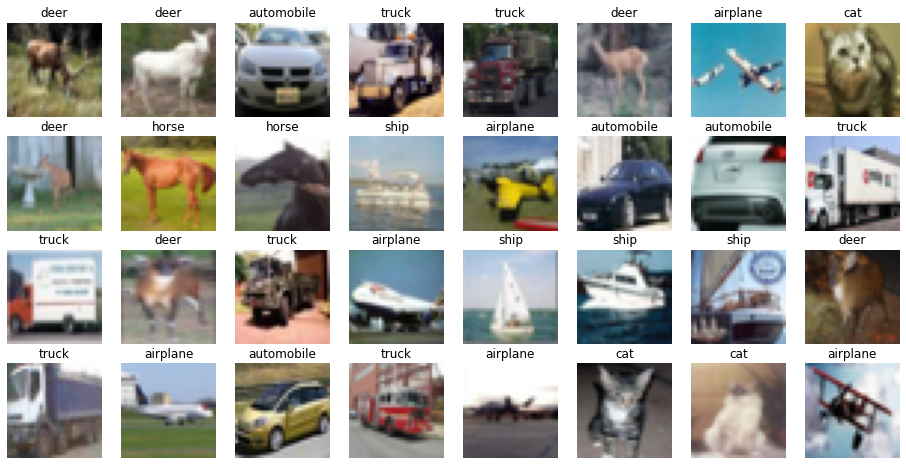

In [ ]:
## Mostra imagens exemplo
CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cols = 8
rows = 4

fig = plt.figure(figsize=(2 * cols, 2 * rows))

for col in range(cols):
    for row in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, col * rows + row + 1)
        ax.axis("off")
        ax.imshow(x_train[random_index, :])
        ax.set_title(CLASSES[y_train[random_index][0]])

plt.show()

### 3. Tranformação dos dados

Nesse processo foi realizado algumas operações:

- Conversão dos rótulos de inteiros para o padrão de codificação one hot.
- Normalização dos dados. Como é conhecido, imagens possuem valores que variam de 0 a 255. Para nosso projeto foi feito uma normalização desses valores entre 0 e 1.

Para facilitar no decorrer do projeto, essas transformações foram adicionadas na função de carregamento dos conjuntos de dados. 

In [ ]:
print('Rótulos inteiros: ', np.unique(y_test))

#Define uma função para carregar a base de dados e fazer as transformações
def carregar_base():
  NUMERO_CLASSES = 10

  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
  #Converte rótulos usando one hot encode
  y_train = keras.utils.to_categorical(y_train, NUMERO_CLASSES)
  y_test = keras.utils.to_categorical(y_test, NUMERO_CLASSES)

  # Conversão de tipos
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  
  # Normalização
  x_train = x_train / 255.0
  x_test = x_test / 255.0

  return x_train, y_train, x_test, y_test

# Chamada a função para carregar base e retornar o conjunto de dados
_, _, _, y_test = carregar_base()

print('Rótulos one hot encode')
print(np.unique(y_test, axis=0))

Rótulos inteiros:  [0 1 2 3 4 5 6 7 8 9]
Rótulos one hot encode
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 4. Função de diagnóstico para apresentação de resultados

Para entendimento dos resultados do modelo, definimos duas funções responsáveis pela exibição da sumarização do resultado retornado pelo treinamento e validação.




In [ ]:
def show_accuracy_history(history):  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def show_loss_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### 5. Função para execução, avaliação e apresentação dos resultados do modelo

Essa função auxiliar recebe como parâmetro um modelo, tamanho do batch e número de épocas de treinamento, e executa as seguintes operações:

- Treinamento do modelo utilizando batch_size e epochs
- Avalia o modelo
- Mostra resultado da avaliação
- Mostra gráfico histórico da acurácia e perca durante as épocas.

In [ ]:
def executar_modelo(model, batch_size, epochs):
  x_train, y_train, x_test, y_test = carregar_base()

  #treinamento
  history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (x_test, y_test)
  )

  #avaliação
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy: %3f' % (score[1] * 100))

  show_accuracy_history(history)
  show_loss_history(history)

### 6. Modelos experimentais

Nessa seção é apresentado alguns experimentos de modelos desenvolvidos para o projeto.

#### **6.1 - Modelo disponibilizado  - para benchmarking - M1**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                        

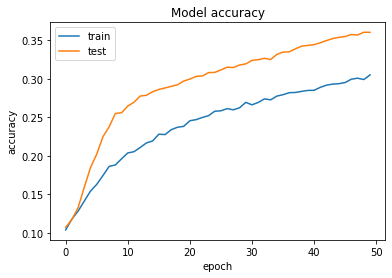

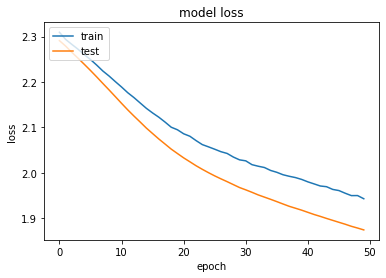

In [ ]:
INPUT_SHAPE = (32,32,3)
EPOCHS = 50
BATCH_SIZE = 128

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

#### **6.2 Modelo 2 - M2E3**

O modelo 1, usa princípios da arquitetura VGG e adiciona mais camadas empilhadas ao modelo inicial.

Trabalho base: https://arxiv.org/pdf/1409.1556.pdf - 
Nesse trabalho é apresentado uma arquitetura de empilhamento de camadas convolucionais com filtros 3 x 3.

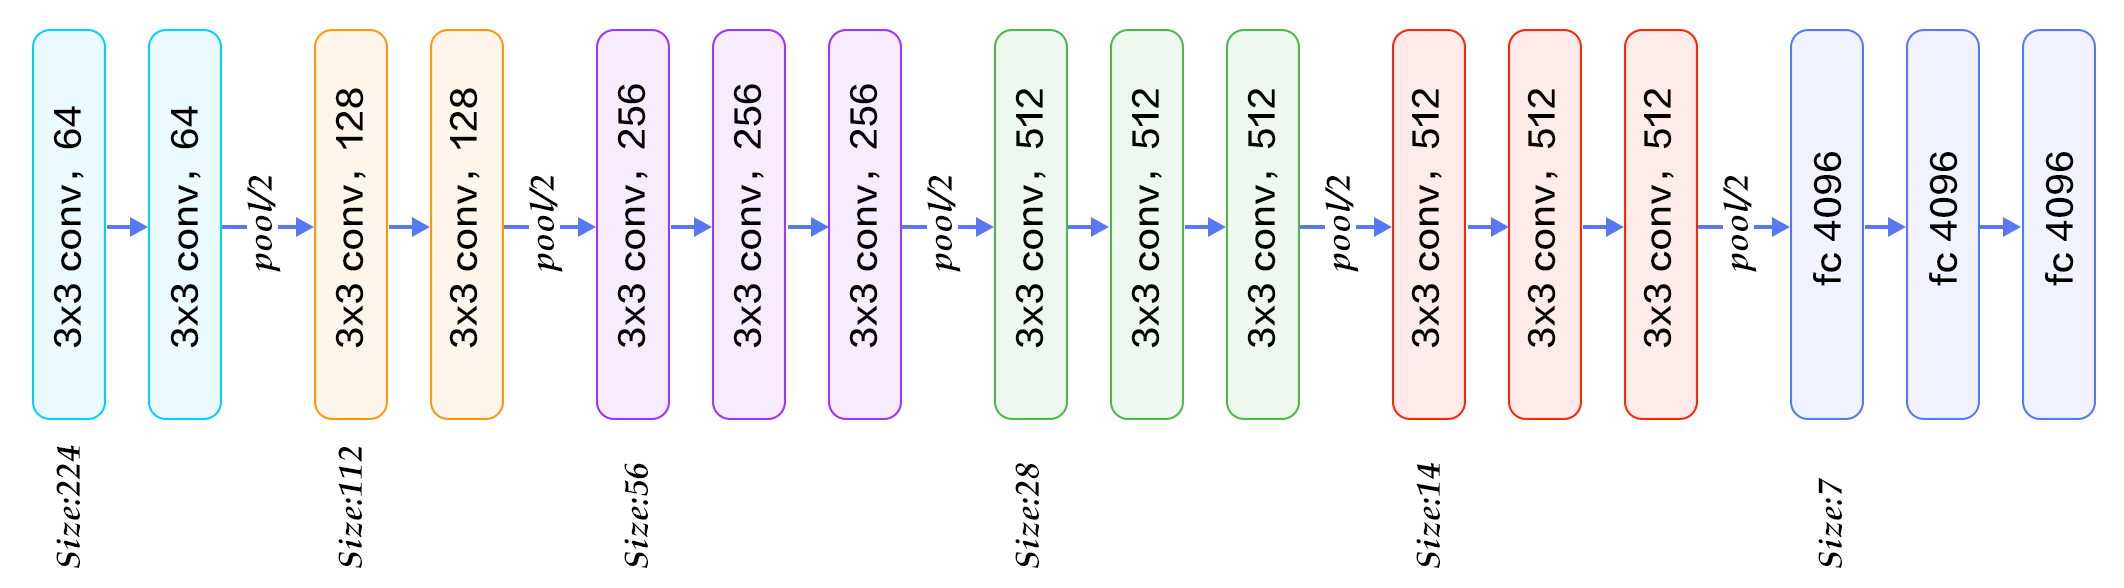

- Otimizador: Adadelta
- A cada novo empilhamento é aumentado a profundidade de rede.
- Usa função de ativação RELU.
- Mantidas as bordas
- Dropout no valor 0.2



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

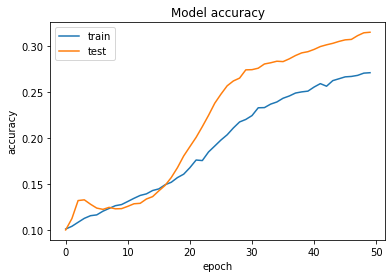

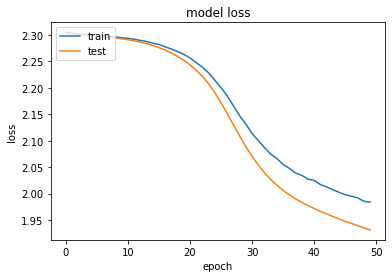

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

#### **6.3 - Modelo 3 - M3E3Max**

- Otimizador: Adamax

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

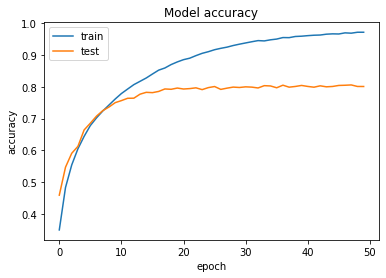

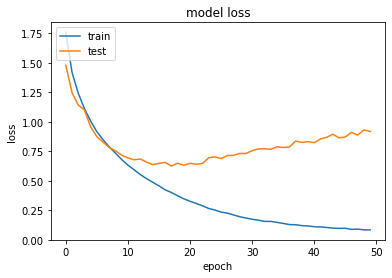

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

##### **Análise dos resultados iniciais**

| Modelo | acc | val_acc
| -------| --- | ------ |
| M1 | 30.52  | 36.04 |
| M2E3 | 27.14 |31.54 |
| M3E3Max | 97.09| 80.07 |


Inicialmente não tivemos uma melhora no resultado do modelo M2E3 utilizando mais camadas empilhadas, mas podemos observar uma variação na taxa de perca entre os dois modelos.

A alteração do otimizador para **Adamax** apresenta um melhoria significativa no aprendizado e na validação, utilizando a mesma arquitetura convolucional.

Também podemos observar que o modelo M2E3Max apresenta, apartir da época 12 o início de um overfit, prologando com muita força nas épocas seguintes, o que sugere a necessidade de ampliar as técnicas de regularização para retardar o aprendizado e melhorar a convergência.

Utilizaremos o modelo M2E3Max nos próximos experimentos.

#### **6.4 - Modelo 3 - Com dropout entre as camadas - M3E3Max + Drop V1**

- Modelo base: M2E3Max
- Regularização: Dropout de 0.25 entre as camadas empilhadas e Dropout 0.25 entre as camadas densas

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

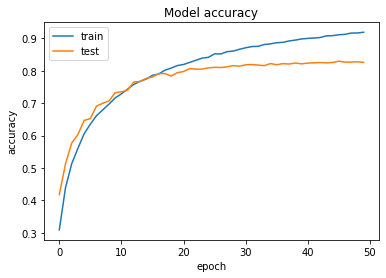

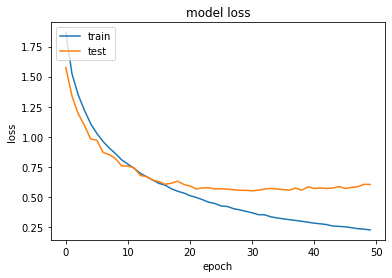

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

#### **6.5 - Modelo 3 - Variação do dropout entre as camadas - M3E3Max + Drop V2**

- Modelo base: M2E3Max
- Regularização: Dropout padrão crescente de (0.25, 0.40, 0.50) entre as camadas empilhadas e Dropout 0.25 entre as camadas densas

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

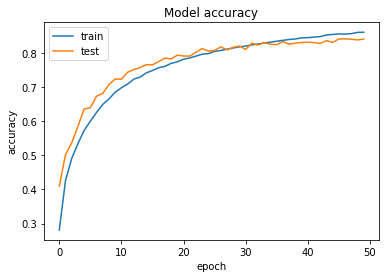

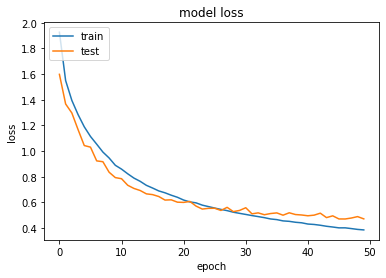

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

**Análise dropout**

É possível observar que a variação do percentual do Dropout entre as camadas empilhadas apresenta uma diminuição do overfit e também melhoria na acurácia.


#### **6.6 - Modelo 3 - Data augmentation - M3E3Max + augmentation V1**

*   List item
*   List item



- Modelo base: M2E3Max
- Com aumento de dados - Random Flip (horizontal), RandomRotation 0.2

O resultado apresenta uma regularização semelhante ao que é feito com Dropout, mas com uma acurácia menor.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

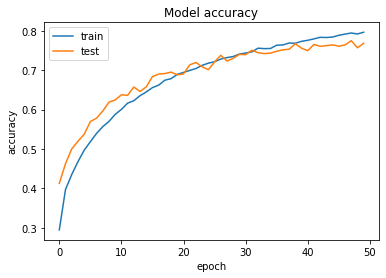

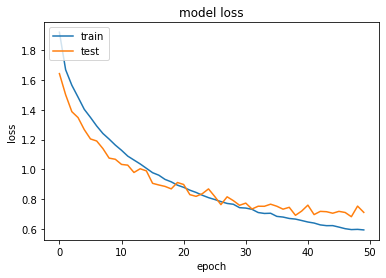

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

#### **6.6 - Modelo 3 - Data augmentation - M3E3Max + augmentation V2**

- Modelo base: M2E3Max
- Com aumento de dados - Random Flip (horizontal), RandomRotation 0.1

O resultado apresenta uma regularização semelhante ao que é feito com Dropout, mas com uma acurácia menor.

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_52 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

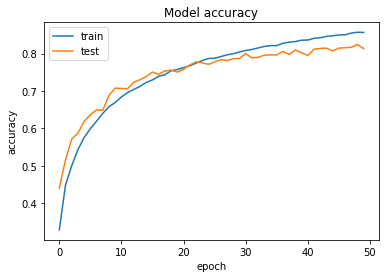

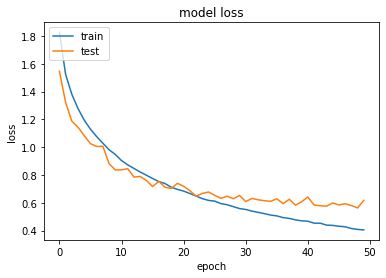

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

##### **Análise dos resultados dropout e aumento de dados**

| Modelo | acc | val_acc
| ------------ | ----- | ----- |
| M3E3Max + Drop V1 | 91.88 | 82.58 |
| M3E3Max + Drop V2 | 85.71 | 84.18 |
| M3E3Max + augmentation V1 | 79.62 | 76.80 |
| M3E3Max + augmentation V2 | 85.65 |81.30 |


Os resultados apresentados sugerem uma compilação utilizando as tecnicas dos modelos **M3E3Max + Drop V2** e **M3E3Max + augmentation**

#### **6.6 - Modelo 3 - M3E3Max + Drop + augmentation**

- Modelo base: M2E3Max
- Com aumento de dados - Random Flip (horizontal), RandomRotation 0.2

O resultado apresenta uma regularização semelhante ao que é feito com Dropout, mas com uma acurácia menor.

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

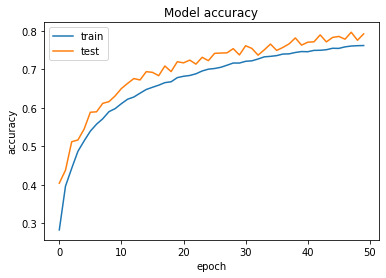

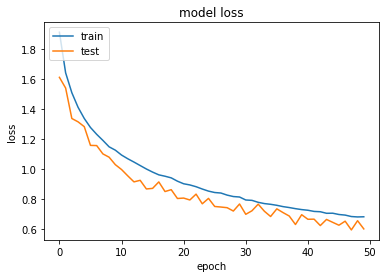

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, EPOCHS)

O modelo utilizando dropout e data augmentation apresenta um processo de aprendizagem mais lento. Também não convergiu.

Essa situação sugere diminuir o percentual de dropout ou aumentar a quantidade de épocas para uma melhor avaliação.

Abaixo mesmo modelo em 100 épocas


####  **6.7 Modelo 3 - M3E3Max + Drop + augmentation 100 épocas**

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

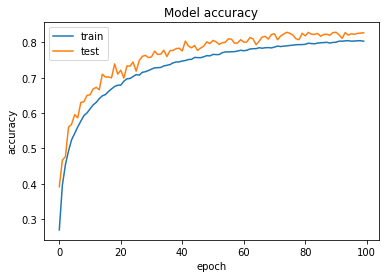

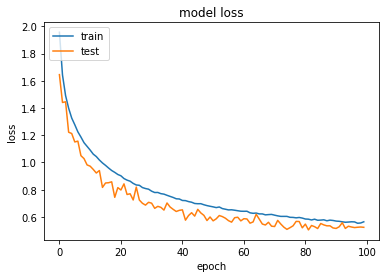

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, 100)

##### **6.8 - Modelo 3 - M3E3Max + Drop + augmentation 100 épocas v2**
Diminuimos a taxa do droput entre as camadas para analise.

- Dropouts (0.2, 0.3, 0.4) entre os empilhamentos

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_72 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

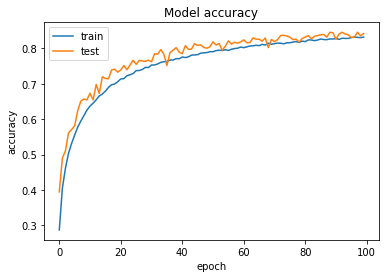

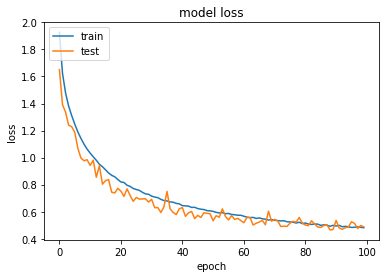

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, 100)

##### **Análise dos resultados dropout + aumento de dados**

| Modelo | acc | val_acc
|--------| --- | ------- |
| M3E3Max + Drop + augmentation 50 épocas | 76.21 |79.24 |
| M3E3Max + Drop + augmentation 100 épocas | 80.35 | 82.74 |
| M3E3Max + Drop + augmentation 100 épocas V2 | 83.17 | 84.18 |

#### **6.9 - Modelo 4 - Aumento de camadas empilhadas - M4E4Max + Drop + augmentation 100 épocas**

Análise com mais duas camadas convolucionais de 256 empilhadas e Dropout ajustado.


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_28 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_77 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

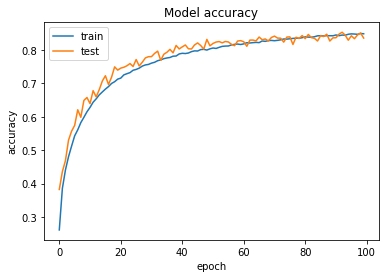

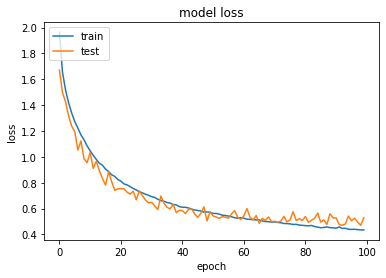

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, 100)

#### **6.10 - Modelo com Adam M4E3Adam - Drop e augmentation 100 épocas**

Para fins de análise verificamos a performance do modelo com otimizador Adam.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                      

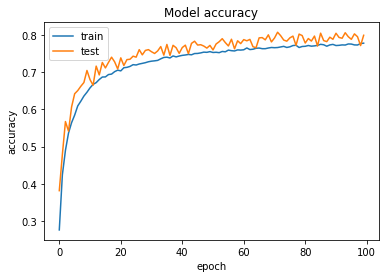

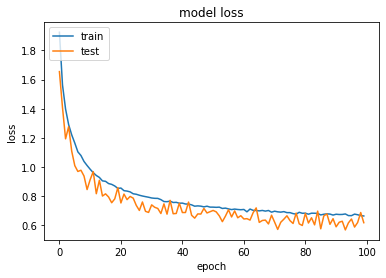

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, 100)

#### **6.11 - Otimização da aprendizagem - Uso de normalização em lote - Modelo M4E4Max + Drop + augmentation + BatchNorm 100 épocas**

O uso de normalização em lote é um técnica para acelerar o aprendizado do modelo.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)      

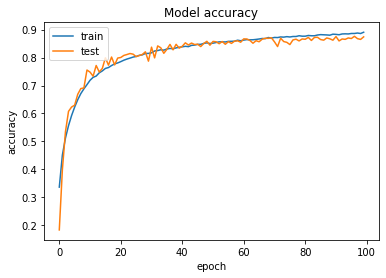

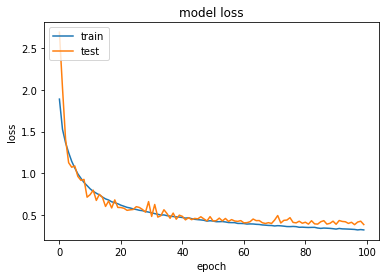

In [ ]:
INPUT_SHAPE = (32,32,3)
BATCH_SIZE = 128
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.1),
])


model = Sequential()
model.add(Input(INPUT_SHAPE))
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

executar_modelo(model, BATCH_SIZE, 100)

#### Resultado final

| Modelo | acc | acc_val
| -------| --- | ------- |
| M1 | 30.52  | 36.04 |
| M2E3 | 27.14 |31.54 |
| M3E3Max | 97.09| 80.07 |
| M3E3Max + Drop V1 | 91.88 | 82.58 |
| M3E3Max + Drop V2 | 85.71 | 84.18 |
| M3E3Max + augmentation V1 | 79.62 | 76.80 |
| M3E3Max + augmentation V2 | 85.65 |81.30 |
| M3E3Max + Drop + augmentation 50 épocas | 76.21 |79.24 |
| M3E3Max + Drop + augmentation 100 épocas | 80.35 | 82.74 |
| M3E3Max + Drop + augmentation 100 épocas V2 | 83.17 | 84.18 |
| M4E4Max + Drop + augmentation 100 épocas | 84.77 | 83.49|
| M4E3Adam - Drop e augmentation 100 épocas | 77.79 | 79.91 |
| M4E4Max + Drop + augmentation + BatchNorm 100 épocas | 89.07 | 87.42 |



- A arquitetura com camadas empilhadas se apresenta como ponto de partida para resolver o problema CIFAR10. É provável que o aumento de camadas mais profundas executando com mais épocas tragam melhores resultados.

- A utilização de dropout crescente entre as camadas retarda o aprendizado, controla o overfit e melhora a acurácia dos testes.

- O uso de aumento de dados sem o uso de dropout nas camadas convolucionais também evitou o overfit.

- O modelo com dropout crescente e augmentation apresentou uma ótima convergência entre aprendizado e validação em um treinamento de 100 épocas

- O uso da normalização em lote acelerou o apredizado e a acurácia na validação.


Não foi utilizado Transfer. Pode ser uma alternativa interessante de experimento.

Como escolher o melhor.

- Navalha de Ockham - Menos complexidade.

### Referências

- CIFAR10 - https://www.cs.toronto.edu/~kriz/cifar.html
- Very depp convolutional networks for large-scale image recognition - https://arxiv.org/pdf/1409.1556.pdf
- Wide Residual Networks - https://arxiv.org/abs/1605.07146
- How to Accelerate Learning of Deep Neural Networks With Batch Normalization - https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/